In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import pandas as pd


In [2]:
data = pd.read_csv('MedicalAppointment.csv')

In [3]:
data['Age'].describe()

,Age
count,110527.000000
mean,37.088874
std,23.110205
min,-1.000000
25%,18.000000
50%,37.000000
75%,55.000000
max,115.000000


In [4]:
data.drop(99832)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2.572134e+12,5651768,F,2016-05-03T09:15:35Z,2016-06-07T00:00:00Z,56,MARIA ORTIZ,0,0,0,0,0,1,No
110523,3.596266e+12,5650093,F,2016-05-03T07:27:33Z,2016-06-07T00:00:00Z,51,MARIA ORTIZ,0,0,0,0,0,1,No
110524,1.557663e+13,5630692,F,2016-04-27T16:03:52Z,2016-06-07T00:00:00Z,21,MARIA ORTIZ,0,0,0,0,0,1,No
110525,9.213493e+13,5630323,F,2016-04-27T15:09:23Z,2016-06-07T00:00:00Z,38,MARIA ORTIZ,0,0,0,0,0,1,No


In [5]:
x =data.iloc[0:80000,5:13]


In [6]:
x= x.drop(columns=['Neighbourhood'])

In [7]:
x

,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
0,62,0,1,0,0,0,0
1,56,0,0,0,0,0,0
2,62,0,0,0,0,0,0
3,8,0,0,0,0,0,0
4,56,0,1,1,0,0,0
...,...,...,...,...,...,...,...
79995,26,0,0,0,0,0,1
79996,5,0,0,0,0,0,0
79997,56,0,0,0,0,0,0
79998,52,0,0,0,0,0,0


In [8]:
y = data.iloc[:80000, -1].to_numpy()

y = np.where(y=='No', 1,0)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
y = torch.tensor(y, dtype=torch.float32)

In [11]:
y = y.reshape((80000,1))

In [12]:
y=y.to(device)

In [13]:
x = torch.tensor(x.to_numpy(), dtype=torch.float32)

In [14]:
x= x.to(device)

In [69]:
class NN(nn.Module):
    def __init__(self, n_feature, hidden):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(n_feature, hidden)
        self.fc2 = nn.Linear(hidden, 1)
    def forward(self, x):
        a1 = F.sigmoid(self.fc1(x))
        a2 = self.fc2(a1)
        return F.sigmoid(a2)

n_feature = 7
hidden = 256
lr = 0.001
batch_size = 64
iters= 180

model = NN(n_feature, hidden).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)


In [70]:
import psutil
import os
p = psutil.Process(os.getpid())

In [71]:

for i in range(iters):
    scores = model(x)
    loss = criterion(scores, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print("Memory used",p.memory_info().rss/1e9)

Memory used 1.249660928


In [72]:
x_test = data.iloc[80000:,5:13]
x_test = x_test.drop('Neighbourhood', axis=1)

In [73]:
x_test = torch.tensor(x_test.to_numpy(), dtype=torch.float32)

In [74]:
y_test = data.iloc[80000:, -1]
y_test = np.where(y_test=='No', 1,0)

y_test = torch.tensor(y_test, dtype=torch.float32)

In [75]:
y_test= y_test.reshape(30527)

In [76]:
x_test = x_test.to(device)
y_test = y_test.to(device)

In [77]:
def acc(model, x_test, y_test):
    nums_samples = 0
    nums_correct =0
    with torch.no_grad():
        scores = model(x_test)
        _, pred  = scores.max(1)
        nums_correct += (pred == y).sum()
        nums_samples += pred.size(0)
    return nums_correct/ nums_samples


In [78]:

with torch.no_grad():
    scores = model(x_test)
    pred  = scores
    print(scores)
    print(pred.shape)


tensor([[0.6133],
        [0.6187],
        [0.6140],
        ...,
        [0.6063],
        [0.6135],
        [0.6166]], device='cuda:0')
torch.Size([30527, 1])


In [79]:
pred = torch.where(pred > 0.5, 1, 0)

In [80]:
pred.reshape(30527)

tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0')

In [81]:
count=0
for i in range(len(y_test)):
    if y_test[i] == pred[i]:
        count+=1
print(count/len(y_test))

0.8073508697218855


In [82]:
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay

In [83]:
x_test = x_test.to('cpu')
y_test = y_test.to('cpu')
pred = pred.to('cpu')

In [84]:
cm = confusion_matrix(y_test, pred)

In [85]:
f1_score(y_test, pred)

0.8934080075399199

In [86]:
roc_auc_score(y_test, pred)

np.float64(0.5)

In [87]:
cm_display = ConfusionMatrixDisplay(cm, display_labels=['No', 'Yes'])


In [88]:
import matplotlib.pyplot as plt

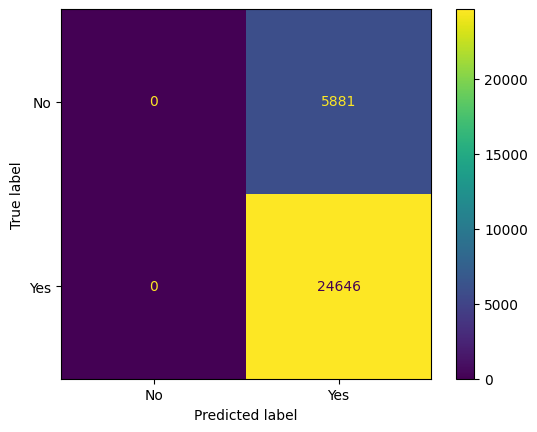

In [89]:
cm_display.plot()